# Demo File

## Data Generation

### Definition of Data Generation Functions

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

# Function to generate donut-shaped data with an inner cluster
def make_donut_data(num_classes=2, num_samples=100, radius_delta=1):
    circle_all = np.array([])
    class_lbls = np.array([])
    
    current_radius = radius_delta * num_classes

    for i in range(num_classes):
        theta = inner_theta = np.random.uniform(0, 2*np.pi, num_samples)

        # Donut data
        circle_x = current_radius * np.cos(theta)
        circle_y = current_radius * np.sin(theta)

        circle_indiv = np.array([circle_x, circle_y]).T
        circle_all = np.vstack((circle_all, circle_indiv)) if circle_all.size else circle_indiv

        class_indiv = np.full(num_samples, i)
        class_lbls = np.concatenate((class_lbls, class_indiv)) if class_lbls.size else class_indiv

        current_radius = current_radius - radius_delta

        
    return circle_all, class_lbls

def make_sinusoidal_wave(amplitude=1, frequency=1.5, phase=0, num_samples=100, num_classes=2, y_difference = 2):
    # Generating x values
    x = np.linspace(0, 4 * np.pi, num_samples)

    x_all = np.array([])
    y_all = np.array([])

    class_lbls = np.array([])

    diff = 0

    # Calculating the sinusoidal wave
    for i in range(num_classes):
        x_all = np.concatenate((x_all, [x]), axis=1) if x_all.size else np.array([x])

        y_indiv = amplitude * np.sin(frequency * x + phase) + diff
        y_all = np.concatenate((y_all, [y_indiv]), axis=1) if y_all.size else np.array([y_indiv])
        diff = diff + y_difference

        class_indiv = np.full(num_samples, i)
        class_lbls = np.concatenate((class_lbls, class_indiv)) if class_lbls.size else class_indiv

    return np.vstack((x_all, y_all)).T, class_lbls

def make_pinwheel_data(num_samples=100, num_classes=2, radius=1, stddev=0):
    # Generating the data for the pinwheel
    angle = np.linspace(0, 2 * np.pi, num_samples)
    data = np.zeros((num_samples * num_classes, 2))
    class_lbls = np.array([])
    for i in range(num_classes):
        ix = range(num_samples * i, num_samples * (i + 1))
        r = np.linspace(0.0, radius, num_samples) + np.random.normal(0, stddev, num_samples)
        data[ix] = np.c_[r * np.cos(angle + i * (2 * np.pi) / num_classes),
                         r * np.sin(angle + i * (2 * np.pi) / num_classes)]

        class_indiv = np.full(num_samples, i)
        class_lbls = np.concatenate((class_lbls, class_indiv)) if class_lbls.size else class_indiv

    return data, class_lbls

def make_bar_data(num_samples=100, num_classes=2, x_init = 0.0, y = 0.5, distance_delta = 1):
    # Generating points for bars
    x = x_init
    bar_all = y_all = np.array([])
    class_lbls = np.array([])
    
    for i in range(num_classes):
        bar_indiv = np.random.rand(num_samples, 2) * 0.5 + np.array([x, y])
        bar_all = np.vstack((bar_all, bar_indiv)) if bar_all.size else bar_indiv
        x = x + distance_delta

        class_indiv = np.full(num_samples, i)
        class_lbls = np.concatenate((class_lbls, class_indiv)) if class_lbls.size else class_indiv

    return bar_all, class_lbls

def get_card_data():
    df = pd.read_csv('data/credit_card.csv')
    # Dropping the CUST_ID column from the data
    df = df.drop('CUST_ID', axis = 1)
    # Handling the missing values if any
    df.fillna(method ='ffill', inplace = True)

    # Preprocessing the data to make it visualizable
 
    # Scaling the Data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    # Normalizing the Data
    X_normalized = normalize(X_scaled)
    
    # Converting the numpy array into a pandas DataFrame
    X_normalized = pd.DataFrame(X_normalized)
    
    # Reducing the dimensions of the data
    pca = PCA(n_components = 2)
    X_principal = pca.fit_transform(X_normalized)
    X_principal = pd.DataFrame(X_principal)
    X_principal.columns = ['P1', 'P2']
    
    
    return np.array(X_principal), None
     

### Generating the Data

In [78]:
#define the colors to be used in the plots
colors = ['red', 'orange', 'lime', 'green', 'blue', 'navy', 'violet']
fig_size = 6

# Params of Data Generation
samples = 500  # Number of samples per class
classes = 2     # Number of classes

# X, Y = make_donut_data(num_classes=classes, num_samples=samples)
# X, Y = make_sinusoidal_wave(num_samples=samples, num_classes=classes)
# X, Y = make_pinwheel_data(num_samples=samples, num_classes=classes, stddev=0)
# X, Y = make_bar_data(num_samples=samples, num_classes=classes)
X, Y = get_card_data()

### Making the Data Plot

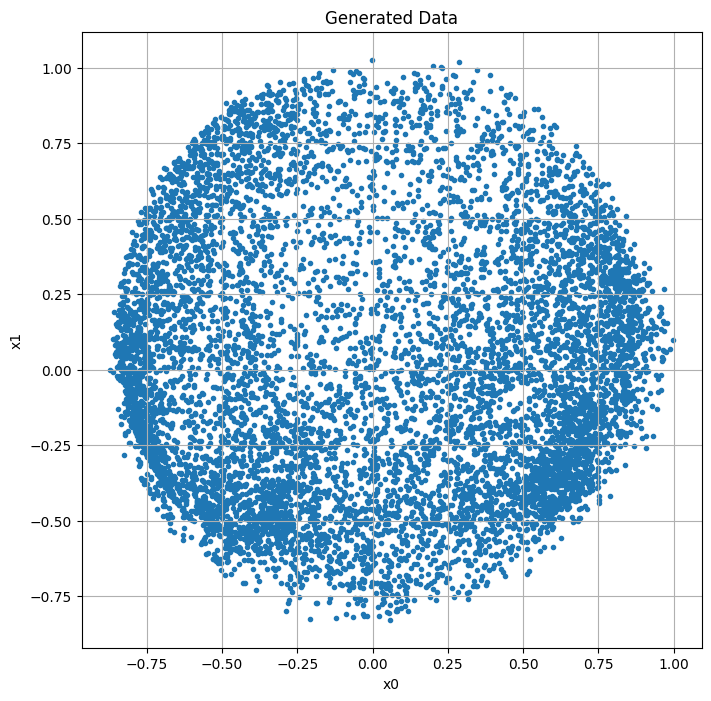

In [79]:
fig = plt.figure(figsize = (8,8))

plt.scatter(X[:, 0], X[:, 1], marker='.')
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Generated Data')
plt.grid()
plt.show()

## Clustering Algorithms

### K-Means Clustering Info

#### Definition
- K-means clustering is a widely used unsupervised machine learning algorithm used to partition a dataset into K distinct, non-overlapping clusters. 
- The primary objective of K-means is to group similar data points together based on their features. 
- Each cluster is represented by a centroid, which is the mean (average) of all data points belonging to that cluster.

#### Advantages
- Ease of Implementation
- Efficiency
- Fast Convergence
- Interpretability
- Versatility

#### Disadvantages
- Sensitivity to Initialization
- Assumption of Equal-Sized, Spherical Clusters
- Impact of Outliers
- Non-Convex Clusters
- Initialization Challenges
- Cluster Shape Assumptions

#### Use Cases
- **Numeric Data**: K-means clustering works well with numerical data. It assumes that the features in the dataset are continuous and can be represented as Euclidean distances.
- **Homogeneous Data**: It performs best with data where clusters are spherical, isotropic, and have similar densities.
- **Linear Separability**: Effective for data with clear boundaries between clusters, assuming clusters are relatively well separated.

### K-Means Clustring Code

Silhouette Score           = 0.45 - KMeans CLustering - init=k-means++ algorithm=lloyd

Silhouette Score           = 0.45 - KMeans CLustering - init=k-means++ algorithm=elkan

Silhouette Score           = 0.45 - KMeans CLustering - init=random algorithm=lloyd

Silhouette Score           = 0.45 - KMeans CLustering - init=random algorithm=elkan



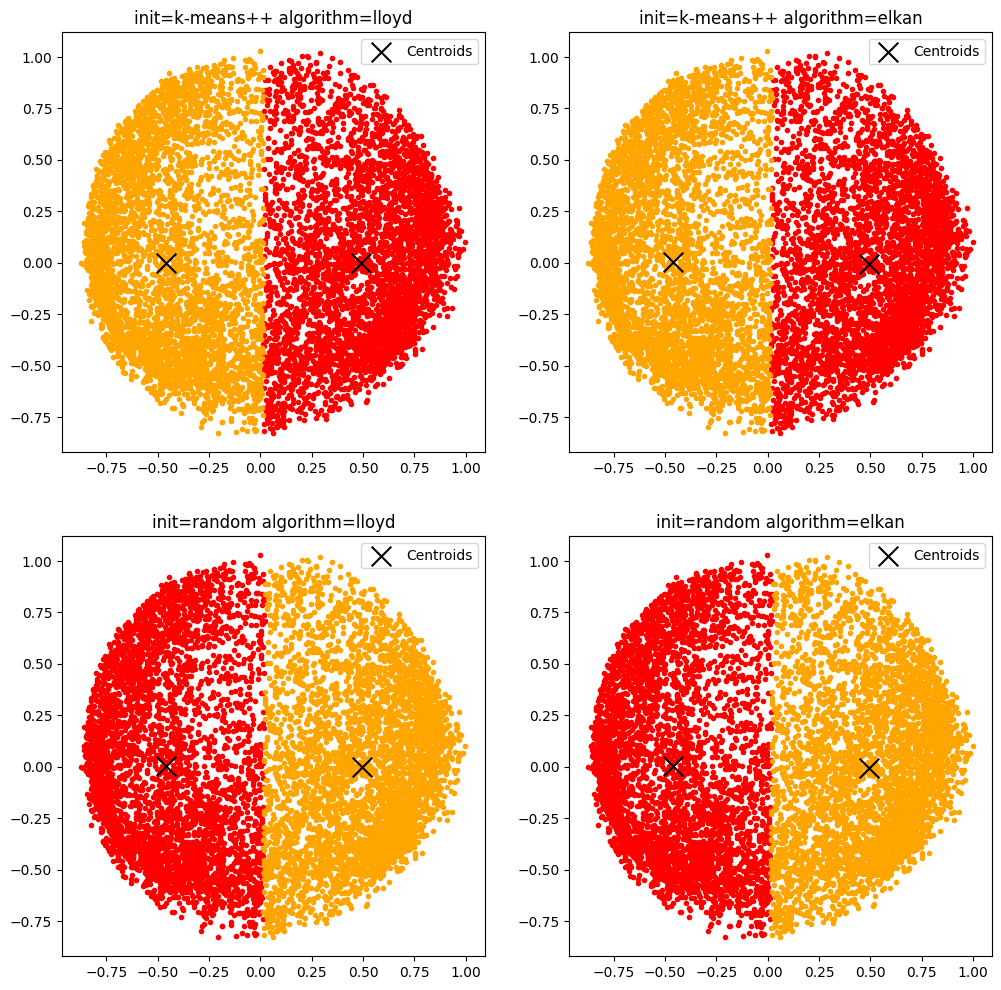

In [80]:
from sklearn.cluster import KMeans

init_array = ['k-means++', 'random']
algo_array = ['lloyd', 'elkan']

fig, axs = plt.subplots(len(init_array), len(algo_array), figsize=(fig_size * len(init_array), fig_size * len(algo_array)))

for i, init in enumerate(init_array):
    for j, algo in enumerate(algo_array):
        ax = axs[i, j]

        model = KMeans(n_clusters=classes, init=init, algorithm=algo, n_init='auto').fit(X)
        targ = model.predict(X)

        for idx, cl in enumerate(np.unique(targ)):
            ax.scatter(X[targ == cl, 0], X[targ == cl, 1], color=colors[idx], marker='.')

        centroids = model.cluster_centers_
        ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, c='black', label='Centroids')
        ax.legend()
        ax.set_title(f"init={init} algorithm={algo}")

        if Y is not None:
            print(f"Adjusted Rand Score        = {adjusted_rand_score(targ, Y):.2f} - KMeans CLustering - init={init} algorithm={algo}")
        print(f"Silhouette Score           = {silhouette_score(X, targ):.2f} - KMeans CLustering - init={init} algorithm={algo}\n")
plt.show()

### Fuzzy C-Means Clustering Info

#### Definition
- Fuzzy C-Means Clustering is a type of unsupervised machine learning technique used for clustering data points into groups or clusters 
- It allows data points to belong to multiple clusters with varying degrees of membership.
- Each data point is associated with a membership value for each cluster, indicating the degree to which it belongs to that cluster.

#### Advantages
- Soft Assignments
- Robust to Noise
- Flexibility
- Granular Insights
- Tolerant of Overlapping Clusters

#### Disadvantages
- Sensitivity to Initial Conditions
- Computationally Intensive
- Subjective Choice of Fuzziness Parameter
- Lack of Convex Clusters
- No Guaranteed Global Optimum

#### Use Cases
- **Fuzzy or Uncertain Data**: FCM is designed for data that is ambiguous or uncertain. It's suitable for situations where a data point might belong to multiple clusters simultaneously.
- **Data with Partial Memberships**: When the underlying structure of the data suggests that some data points may belong to more than one cluster with varying degrees of membership.
- **Mixed or Overlapping Clusters**: It's effective for datasets where clusters may have some degree of overlap.

### Fuzzy C-Means Clustering Code

                 0         1
0     1.083697e-02  0.989163
1     2.651979e-03  0.997348
2     9.995990e-01  0.000401
3     1.027184e-08  1.000000
4     1.032329e-03  0.998968
...            ...       ...
8945  9.999051e-01  0.000095
8946  9.994397e-01  0.000560
8947  9.902294e-01  0.009771
8948  3.395339e-05  0.999966
8949  4.847461e-01  0.515254

[8950 rows x 2 columns]
Silhouette Score           = 0.45 - Fuzzy C-Means



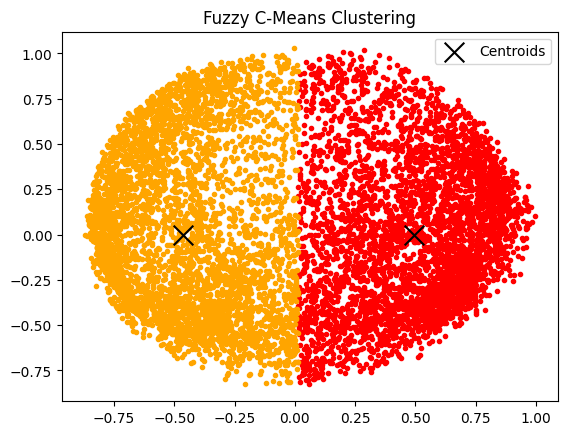

In [81]:
from skfuzzy import cmeans, cmeans_predict

centers, u, u0, d, jm, p, fpc = cmeans(data = X.T, c = classes, m = 1.25, error = 0.05, maxiter = 1000)
target2 = np.argmax(u, axis=0)

for idx, cl in enumerate(np.unique(target2)):
    plt.scatter(X[target2 == cl, 0], X[target2 == cl, 1], color=colors[idx], marker='.')
    
plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=200, c='black', label='Centroids')
plt.legend()
plt.title("Fuzzy C-Means Clustering")

# Printing membership matrix
print(pd.DataFrame(u.T))

if Y is not None:
    print(f"Adjusted Rand Score        = {adjusted_rand_score(target2, Y):.2f} - Fuzzy C-Means")
print(f"Silhouette Score           = {silhouette_score(X, target2):.2f} - Fuzzy C-Means\n")

### Spectral Clustering Info

#### Definition
- Spectral clustering is a clustering technique used in machine learning and data analysis to partition a dataset into cohesive clusters based on the spectral properties of a similarity or affinity matrix derived from the data. 
- It is a powerful clustering method that can uncover complex cluster structures, including non-convex and disconnected clusters. 
- Spectral clustering is particularly useful when traditional methods like K-means struggle to capture the underlying cluster relationships.

#### Advantages
- Ability to Capture Complex Structures
- No Assumption of Cluster Shape
- Robust to Noise and Outliers
- Dimensionality Reduction
- Cluster Visualization

#### Disadvantages
- Computational Complexity
- Scaling Issues
- Sensitivity to Affinity Measure
- Lack of Deterministic Result
- Interpretability of Eigenvectors

#### Use Cases
- **Non-linear Data**: Spectral clustering is particularly useful for non-linearly separable data. It's effective for identifying clusters with complex shapes and structures.
- **Graph-Based Data**: Works well with data that can be represented as a similarity or distance graph. It can be applied to various data types, including numeric and non-numeric data.
- **Manifold Structure**: Suitable for data with a manifold structure where traditional distance-based clustering methods might fail.

### Spectral Clustering Code

Silhouette Score           = 0.45 - Spectral Clustering - nearest_neighbors

Silhouette Score           = 0.45 - Spectral Clustering - rbf

Silhouette Score           = 0.45 - Spectral Clustering - poly

Silhouette Score           = 0.45 - Spectral Clustering - polynomial

Silhouette Score           = 0.45 - Spectral Clustering - laplacian

Silhouette Score           = 0.45 - Spectral Clustering - sigmoid



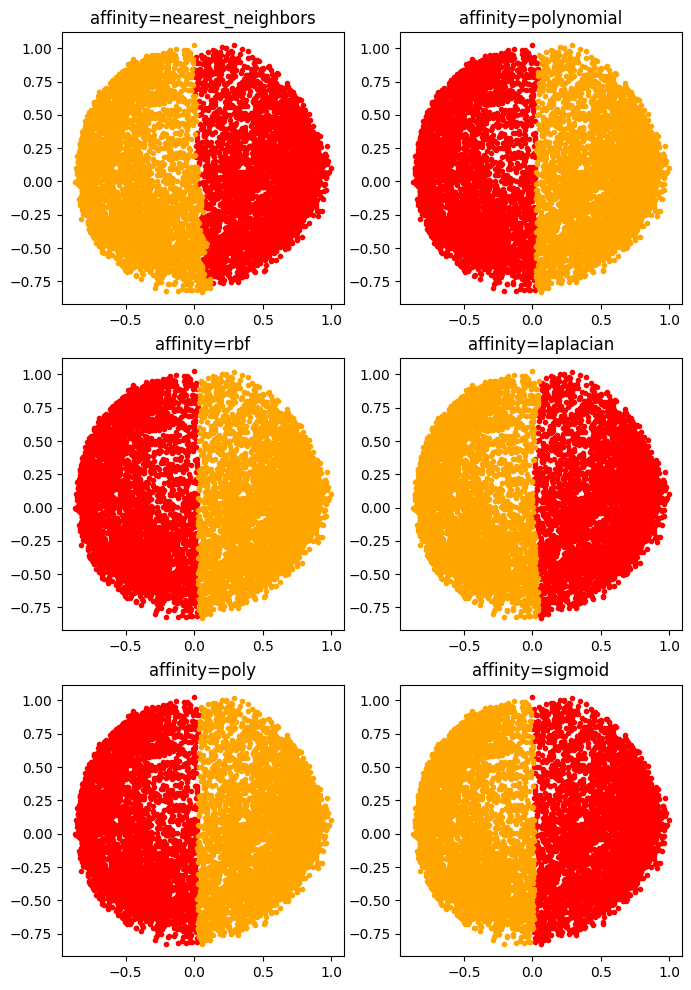

In [82]:
from sklearn.cluster import SpectralClustering

aff_array = ['nearest_neighbors', 'rbf', 'poly', 
                'polynomial', 'laplacian', 'sigmoid']
# you can use these kernels for affinity but they dont always work
# ['additive_chi2', 'chi2', 'linear', 'cosine']

fig, axs = plt.subplots(3, 2, figsize=(8, 12))

for i, aff in enumerate(aff_array):
    m = int(i / (len(aff_array) / 2))
    n = int(i % (len(aff_array) / 2))
    ax = axs[n, m]

    targ = SpectralClustering(n_clusters=classes, affinity=aff, gamma=0.5).fit_predict(X)

    for idx, cl in enumerate(np.unique(targ)):
        ax.scatter(X[targ == cl, 0], X[targ == cl, 1], color=colors[idx], marker='.')
        ax.set_title(f"affinity={aff}")

    if Y is not None:
        print(f"Adjusted Rand Score        = {adjusted_rand_score(targ, Y):.2f} - Spectral Clustering - {aff}")
    print(f"Silhouette Score           = {silhouette_score(X, targ):.2f} - Spectral Clustering - {aff}\n")
plt.show()

### Agglomerative Clustering Info

#### Definition
- Agglomerative clustering is a hierarchical clustering technique used in machine learning and data analysis. 
- It is a bottom-up approach to clustering, where each data point initially forms its own cluster, and then these clusters are successively merged into larger clusters based on a similarity or dissimilarity metric. 
- The process continues until all data points belong to a single, all-encompassing cluster.
- Recursively merges pair of clusters of sample data; uses linkage distance.

#### Advantages
- Simple to implement
- Hierarchical structure
- No fixed number of clusters required
- Robust to noise

#### Disadvantages
- Computationally expensive
- Sensitive to initial conditions
- Difficulty with large datasets
- Difficulty in handling non-globular shapes
- Memory consumption

#### Use Cases
- **All Data Types**: Agglomerative clustering can handle different types of data, be it numerical or categorical, and can work with various distance/similarity measures.
- **Large Datasets**: It can handle larger datasets, but computational complexity increases with the number of data points.
- **Hierarchical Structure**: Effective for data with hierarchical structures, where the formation of clusters follows a nested or hierarchical pattern.

### Agglomerative Clustering Code

Silhouette Score           = 0.43 - Agglomerative Clustering - linkage=complete metric=cityblock

Silhouette Score           = 0.40 - Agglomerative Clustering - linkage=average metric=cityblock

Silhouette Score           = 0.19 - Agglomerative Clustering - linkage=single metric=cityblock

Silhouette Score           = 0.43 - Agglomerative Clustering - linkage=complete metric=l1

Silhouette Score           = 0.40 - Agglomerative Clustering - linkage=average metric=l1

Silhouette Score           = 0.19 - Agglomerative Clustering - linkage=single metric=l1

Silhouette Score           = 0.31 - Agglomerative Clustering - linkage=complete metric=l2

Silhouette Score           = 0.38 - Agglomerative Clustering - linkage=average metric=l2

Silhouette Score           = 0.19 - Agglomerative Clustering - linkage=single metric=l2

Silhouette Score           = 0.43 - Agglomerative Clustering - linkage=complete metric=manhattan

Silhouette Score           = 0.40 - Agglomerative Clustering - linkage=

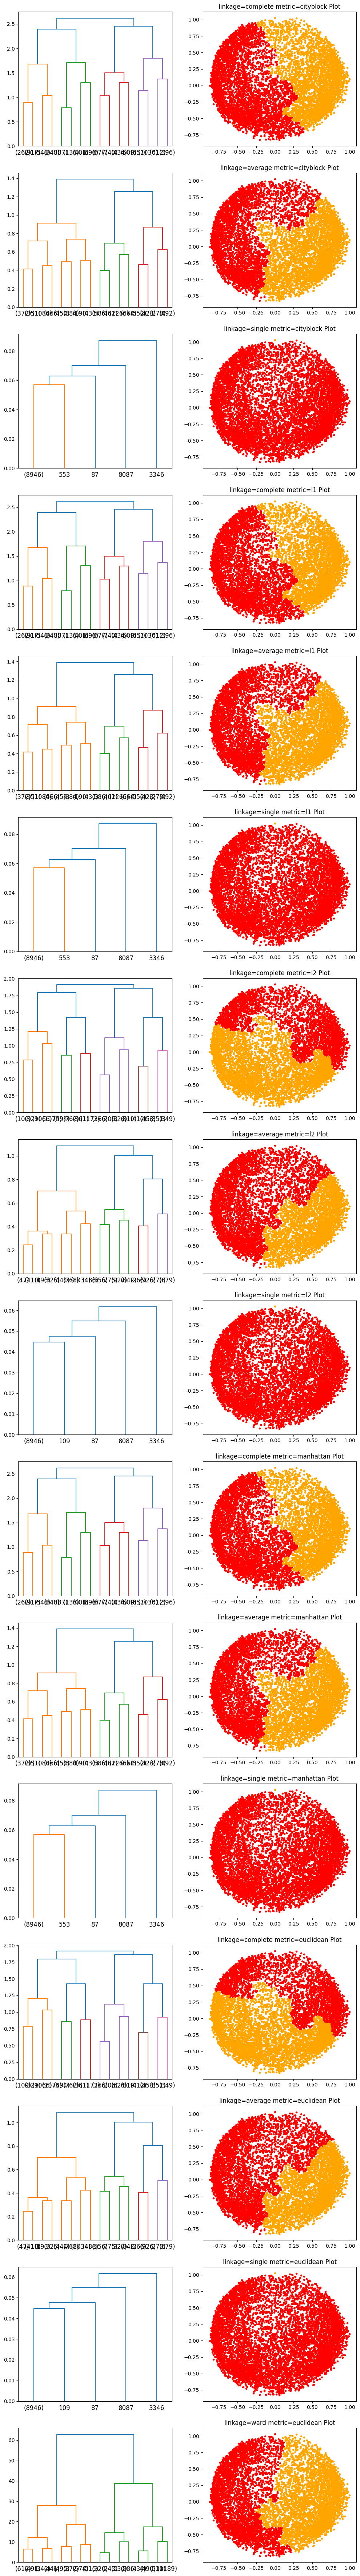

In [83]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def plot_data(model, lin, met, ax):
    model.set_params(n_clusters=classes, distance_threshold=None)
    targ = model.fit_predict(X)
    
    if Y is not None: 
        print(f"Adjusted Rand Score        = {adjusted_rand_score(targ, Y):.2f} - Agglomerative Clustering - linkage={lin} metric={met}")
    print(f"Silhouette Score           = {silhouette_score(X, targ):.2f} - Agglomerative Clustering - linkage={lin} metric={met}\n")

    for idx, cl in enumerate(np.unique(targ)):
        ax.scatter(X[targ == cl, 0], X[targ == cl, 1], color=colors[idx], marker='.')
        ax.set_title(f"linkage={lin} metric={met} Plot")
        

met_array = ['cityblock', 'l1', 'l2', 'manhattan', 'euclidean']
lin_array = ['complete', 'average', 'single'] # 'ward' only works on euclidian thus it is appended only in the end

fig, axs = plt.subplots(len(lin_array) * len(met_array) + 1, 2, figsize=(fig_size * 2, fig_size * len(lin_array) * len(met_array) + 1))

m = 0
for i, met in enumerate(met_array):
    if(met == 'euclidean'):
        lin_array.append('ward')
    for j, lin in enumerate(lin_array):
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=lin, metric=met)
        model = model.fit(X)

        plot_dendrogram(model, truncate_mode="level", p=3, ax=axs[m, 0])
        plot_data(model, lin, met, ax=axs[m, 1])
        m = m + 1

plt.show()

## References

- **KMeans Clustering**: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- **Fuzzy CMeans Clustering**: https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.html#skfuzzy.cmeans
- **Spectral Clustering**: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
- **Agglomerative Clustering**: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
